Генерация имен. LSTM

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import os
bos = " "

with open("names.txt") as file:
    names = file.read().split('\n')
    names = [bos + name for name in names]
    names = names[1:]

In [6]:
print(len(names))

19868


16


(array([6.800e+01, 0.000e+00, 3.990e+02, 0.000e+00, 1.844e+03, 0.000e+00,
        4.143e+03, 0.000e+00, 0.000e+00, 5.014e+03, 0.000e+00, 4.083e+03,
        0.000e+00, 2.476e+03, 0.000e+00, 0.000e+00, 1.178e+03, 0.000e+00,
        4.830e+02, 0.000e+00, 1.300e+02, 0.000e+00, 0.000e+00, 4.100e+01,
        0.000e+00, 7.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 3.        ,  3.43333333,  3.86666667,  4.3       ,  4.73333333,
         5.16666667,  5.6       ,  6.03333333,  6.46666667,  6.9       ,
         7.33333333,  7.76666667,  8.2       ,  8.63333333,  9.06666667,
         9.5       ,  9.93333333, 10.36666667, 10.8       , 11.23333333,
        11.66666667, 12.1       , 12.53333333, 12.96666667, 13.4       ,
        13.83333333, 14.26666667, 14.7       , 15.13333333, 15.56666667,
        16.        ]),
 <a list of 30 Patch objects>)

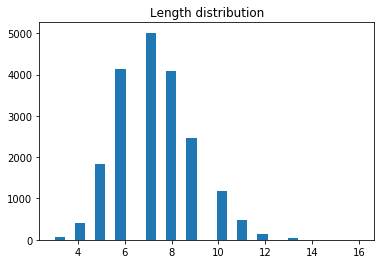

In [7]:
MAX_LEN = max(map(len, names))
print(MAX_LEN)

plt.title('Length distribution')
plt.hist(list(map(len, names)), bins = 30)

In [8]:
symbols = set("".join(names))
symbols = list(symbols)

print(len(symbols))
print(symbols)

54
['a', 'm', 'Q', ' ', 'q', 'Y', 'I', 'c', 'U', 'o', 'u', 'W', 'v', 'k', 't', 'J', 'L', 'X', 'M', 'Z', 'd', 's', 'l', 'j', 'S', 'z', "'", 'p', 'A', 'K', 'H', 'w', 'V', 'F', 'r', 'n', 'B', 'E', 'y', 'h', 'N', 'D', 'e', 'G', 'P', 'f', 'i', 'x', 'C', 'R', 'T', 'O', 'b', 'g']


In [9]:
sym2id = {symbol : symbols.index(symbol) for symbol in symbols}
print(sym2id)

{'a': 0, 'm': 1, 'Q': 2, ' ': 3, 'q': 4, 'Y': 5, 'I': 6, 'c': 7, 'U': 8, 'o': 9, 'u': 10, 'W': 11, 'v': 12, 'k': 13, 't': 14, 'J': 15, 'L': 16, 'X': 17, 'M': 18, 'Z': 19, 'd': 20, 's': 21, 'l': 22, 'j': 23, 'S': 24, 'z': 25, "'": 26, 'p': 27, 'A': 28, 'K': 29, 'H': 30, 'w': 31, 'V': 32, 'F': 33, 'r': 34, 'n': 35, 'B': 36, 'E': 37, 'y': 38, 'h': 39, 'N': 40, 'D': 41, 'e': 42, 'G': 43, 'P': 44, 'f': 45, 'i': 46, 'x': 47, 'C': 48, 'R': 49, 'T': 50, 'O': 51, 'b': 52, 'g': 53}


In [10]:
def nam2vec(names):
    pad = sym2id[' ']
    names_vec = np.zeros([len(names), MAX_LEN], 'int32') + pad
    
    for i in range(len(names)):
        name_vec = [sym2id[sym] for sym in names[i]]
        names_vec[i, :len(name_vec)] = name_vec
        
    return names_vec

In [13]:
nam2vec(['Dima', 'Roma'])

array([[41, 46,  1,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [49,  9,  1,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]])

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

In [61]:
class SymbolCreatorCell(nn.Module):
    def __init__(self, alph_size = len(symbols), emb_dim = 16, hid_dim = 64):
        super().__init__()
        
        self.hid_dim = hid_dim
        
        self.sym2emb = nn.Embedding(alph_size, emb_dim)
        self.emb2hid = nn.LSTMCell(emb_dim, hid_dim)
        self.hid2log = nn.Linear(hid_dim, alph_size)
        
    def forward(self, sym, prev):
        (h_prev, c_prev) = prev
        (h_next, c_next) = self.emb2hid(self.sym2emb(sym), (h_prev, c_prev))
        log = self.hid2log(h_next)
        
        return (h_next, c_next), func.log_softmax(log, -1)
    
    def init_state(self, batch_size):
        return torch.zeros(batch_size, self.hid_dim), torch.zeros(batch_size, self.hid_dim)

In [62]:
def creation_loop(creator_cell, batch_vec):
    batch_size, max_length = batch_vec.size()
    state = creator_cell.init_state(batch_size)
    logps = []
    
    for sym in batch_vec.transpose(0, 1):
        state, logp = creator_cell(sym, state)
        logps.append(logp)
    
    return torch.stack(logps, dim = 1)

In [75]:
from IPython.display import clear_output
from random import sample

creator_cell = SymbolCreatorCell()
crit = optim.Adam(creator_cell.parameters())
history = []
names_history = [[]]

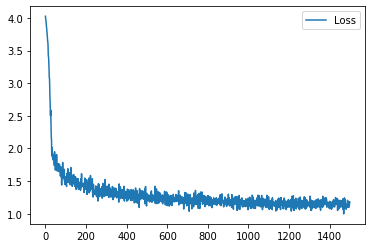

In [76]:
batch_size = 32

for i in range(1500):
    batch_vec = torch.LongTensor(nam2vec(sample(names, batch_size)))
    logps = creation_loop(creator_cell, batch_vec)

    loss = func.nll_loss(logps[:, :-1].contiguous().view(-1, len(symbols)), batch_vec[:, 1:].contiguous().view(-1))

    crit.zero_grad()
    loss.backward()
    crit.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        
        buffer = []
        for j in range(10):
            buffer.append(create_name(creator_cell, ' '))
        
        names_history.append(buffer)
        
        clear_output(True)
        plt.plot(history, label = 'Loss')
        plt.legend()
        plt.show()

In [25]:
def create_name(creator_cell, start = ' ', t = 1.0):
    seq = torch.LongTensor([[sym2id[sym] for sym in start]])
    state = creator_cell.init_state(batch_size = 1)
    
    for i in range(len(start) - 1):
        state, _ = creator_cell(seq[:, i], state)
    
    for i in range(MAX_LEN - len(start)):
        state, logp = creator_cell(seq[:, - 1], state)
        p = func.softmax(logp / t, dim = -1).data.numpy()[0]
        
        next_vec = torch.LongTensor([[np.random.choice(len(symbols), p = p)]])
        seq = torch.cat([seq, next_vec], dim = 1)
        
    return ''.join([symbols[ind] for ind in seq.data.numpy()[0]])

In [81]:
for i in range(20):
    print(create_name(creator_cell, ' Kek'))

 Kekanis        
 Kekpiny        
 Kekthou        
 Kekarina       
 Kekvareo       
 Kekerat        
 Kekosima       
 Keky           
 Kekaminn       
 Keksedo        
 Kekinre        
 Kekbi          
 Kekong         
 Kek            
 Kekqli         
 Keksa          
 Kekhas         
 Kekhzy         
 Keka           
 Kekgallo       


In [80]:
for i in range(len(names_history)):
    print("Step ", i)
    for name in names_history[i]:
        print(name)

Step  0
Step  1
 Tst            
 lh  a          
 JkPoc a        
 Si             
 Qeo   a        
 lmGoe      in  
 Yziyca         
 fhiR           
 uT   i  i      
 tq y       n   
Step  2
 Ftrpar         
 Mdtdeu t    a  
 wmectriea      
 u seaed        
 thQn z         
 zgdnlno        
 BeDt         r 
 oerueCi i      
 czoeLlgma      
 ts ier ia      
Step  3
 uEkaoou        
 Jcela          
 Ltdnnnd        
 Aletoa         
 Oaiars o       
 mXoda          
 ioeddefcot     
 Lzrlco         
 Ynien          
 iii            
Step  4
 Ikrvab         
 Gytlho         
 zzleba         
 Ropeinp        
 coindgag       
 Jifmrn         
 ediy           
 Byia           
 Bpaia          
 AQsasnla       
Step  5
 Rhonona        
 Ayir           
 Erdsar         
 Berfslaba      
 Ceria          
 urromt  s      
 Jiama          
 qrsi           
 Bolioyez       
 Eenesio        
Step  6
 Nlseeeiin      
 Gorittid       
 Srjahyia       
 Xriena         
 Hlin           
 Ixcegeno